In [1]:
import pandas as pd
import logging
from collections import defaultdict

import torch
import pytorch_lightning as pl
from pathlib import Path
from torch.utils.data import DataLoader
import seisbench
import seisbench.models as sbm
from seisLM.evaluation import pick_eval
import numpy as np
import matplotlib.pyplot as plt
from seisLM.utils import project_path
from phasepick_model_registry import ckpt_registry, plot_kwargs
from matplotlib import rcParams
from ml_collections import config_dict


/scicore/home/dokman0000/liu0003/miniconda3/envs/seisbench/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
training_fracs = ['0.05', '0.1', '0.2', '0.5', '1.0']
eval_set = 'test'
seislm_variant = 'base'
data_name = 'ETHZ'
# data_name = 'GEOFON'
# data_name = 'STEAD'
assert data_name in ckpt_registry.keys()

In [3]:
all_training_frac_results = {}

for train_frac in training_fracs:
  model_result = {}

  for model_name, ckpt_paths in ckpt_registry[data_name].items():

    model_identifier = ckpt_paths[train_frac].split('/')[-3]

    base_pred_path = (
      Path(project_path.EVAL_SAVE_DIR)
      / f"{model_identifier}_{data_name}"
    )

    event_detection_result = pick_eval.get_results_event_detection(
      base_pred_path / f"{eval_set}_task1.csv")

    phase_identification_result = pick_eval.get_results_phase_identification(
      base_pred_path / f"{eval_set}_task23.csv"
    )

    onset_determination_result = pick_eval.get_results_onset_determination(
      base_pred_path / f"{eval_set}_task23.csv"
    )

    model_result[model_name] = {
      'event_detection': event_detection_result,
      'phase_identification': phase_identification_result,
      'onset_determination': onset_determination_result
    }

  all_training_frac_results[train_frac] = model_result

## Global figure setting

In [4]:
A4_WIDTH = 8.27
FONT_SIZE = 12

## Task 1

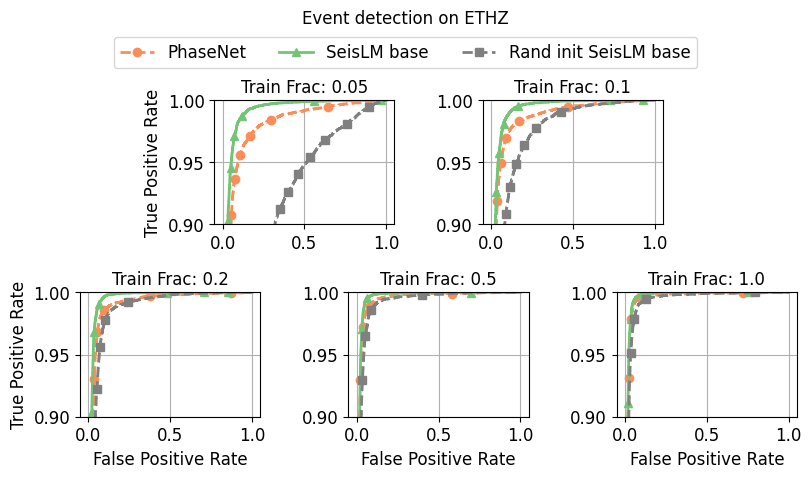

In [20]:
# fig, axes = plt.subplots(2, 3, figsize=(A4_WIDTH, A4_WIDTH/1.7))  # A4 paper size, width: 8.27 inches, height: 11.69 inches
# axes = axes.ravel()  # Flatten the 2x3 array of axes to easily iterate
fig = plt.figure(figsize=(A4_WIDTH, A4_WIDTH/1.7))
gs = fig.add_gridspec(2, 6)

ax00 = fig.add_subplot(gs[0, 1:3])
ax01 = fig.add_subplot(gs[0, 3:5])
ax10 = fig.add_subplot(gs[1, 0:2])
ax11 = fig.add_subplot(gs[1, 2:4])
ax12 = fig.add_subplot(gs[1, 4:6])

axes = [ax00, ax01, ax10, ax11, ax12]

plt.rcParams.update({
    'font.size': FONT_SIZE,  # General font size
    'axes.titlesize': FONT_SIZE,  # Subplot titles
    'figure.titlesize': FONT_SIZE,  # Suptitle (main title)
    'legend.fontsize': FONT_SIZE,  # Legend font size
    'pdf.fonttype': 42,  # Embed fonts in PDF for better compatibility
})


# Initialize variables to store the handles and labels for the legend
handles, labels = None, None

i = 0

# Plotting loop
for train_frac, result_of_models in all_training_frac_results.items():
    ax = axes[i]
    for model_name, model_result in result_of_models.items():
      if ('seislm' not in model_name.lower()) or (
        'seislm' in model_name.lower() and seislm_variant in model_name.lower()
      ):
        line, = ax.plot(
            model_result['event_detection']['fpr'],
            model_result['event_detection']['tpr'],
            label=model_name.replace('_', ' '),
            markevery=250,
            **plot_kwargs[model_name]
        )

    ax.set_ylim([0.9, 1])
    if i >= 2:
        ax.set_xlabel('False Positive Rate')
    ax.grid(True)
    ax.set_title(f'Train Frac: {train_frac}')

    # Store the handles and labels for the legend (only capture once)
    if handles is None and labels is None:
        handles, labels = ax.get_legend_handles_labels()

    i += 1

# Add y-axis labels
axes[0].set_ylabel("True Positive Rate")
axes[2].set_ylabel("True Positive Rate")

# Add a single legend at the top
fig.legend(handles, labels, loc='upper center', ncol=len(labels), bbox_to_anchor=(0.5, 0.94), frameon=True)

# Add a super title for the figure
plt.suptitle(f'Event detection on {data_name}')

# Adjust layout to fit everything neatly
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the legend

# Show the plot
plt.show()

# Save the figure with embedded fonts
fig.savefig(project_path.FIGURE_DIR + f'/event_detection_{data_name}.pdf', bbox_inches='tight')


# Task 2

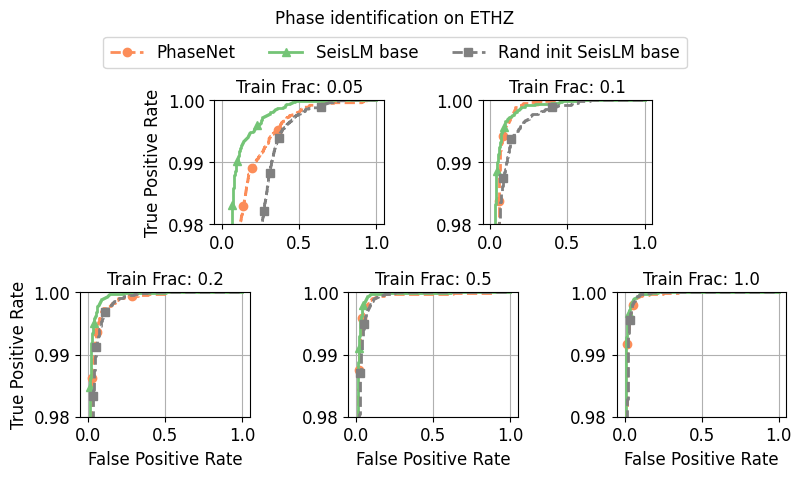

In [31]:
# fig, axes = plt.subplots(2, 3, figsize=(A4_WIDTH, A4_WIDTH/1.7))  # A4 paper size, width: 8.27 inches, height: 11.69 inches
# axes = axes.ravel()  # Flatten the 2x3 array of axes to easily iterate

fig = plt.figure(figsize=(A4_WIDTH, A4_WIDTH/1.7))
gs = fig.add_gridspec(2, 6)

ax00 = fig.add_subplot(gs[0, 1:3])
ax01 = fig.add_subplot(gs[0, 3:5])
ax10 = fig.add_subplot(gs[1, 0:2])
ax11 = fig.add_subplot(gs[1, 2:4])
ax12 = fig.add_subplot(gs[1, 4:6])

axes = [ax00, ax01, ax10, ax11, ax12]



plt.rcParams.update({
    'font.size': FONT_SIZE,  # General font size
    'axes.titlesize': FONT_SIZE,  # Subplot titles
    'figure.titlesize': FONT_SIZE,  # Suptitle (main title)
    'legend.fontsize': FONT_SIZE,  # Legend font size
    'pdf.fonttype': 42,  # Embed fonts in PDF for better compatibility
})



# Initialize variables to store the handles and labels for the legend
handles, labels = None, None

i = 0

# Plotting loop
for train_frac, result_of_models in all_training_frac_results.items():
    ax = axes[i]
    for model_name, model_result in result_of_models.items():
      if ('seislm' not in model_name.lower()) or (
        'seislm' in model_name.lower() and seislm_variant in model_name.lower()
      ):

        line, = ax.plot(
            model_result['phase_identification']['fpr'],
            model_result['phase_identification']['tpr'],
            # label=model_name,
            label=model_name.replace('_', ' '),
            markevery=100,
            **plot_kwargs[model_name]
        )

    ax.set_ylim([0.98, 1])
    if i >= 2:
        ax.set_xlabel('False Positive Rate')
    ax.grid(True)
    ax.set_title(f'Train Frac: {train_frac}')

    # Store the handles and labels for the legend (only capture once)
    if handles is None and labels is None:
        handles, labels = ax.get_legend_handles_labels()

    i += 1

# Add y-axis labels
axes[0].set_ylabel("True Positive Rate")
axes[2].set_ylabel("True Positive Rate")

# Add a single legend at the top
fig.legend(handles, labels, loc='upper center', ncol=len(labels), bbox_to_anchor=(0.5, 0.94), frameon=True)

# Add a super title for the figure
plt.suptitle(f'Phase identification on {data_name}')

# Adjust layout to fit everything neatly
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the legend

# Show the plot
plt.show()

# Save the figure with embedded fonts
fig.savefig(project_path.FIGURE_DIR + f'/phase_identification_{data_name}.pdf', bbox_inches='tight')


# Task 3

In [34]:
bins = np.linspace(-2.5, 2.5, 50)

# Create the subplots

for onset_type in ['P_onset_diff', 'S_onset_diff']:
  fig, axes = plt.subplots(len(result_of_models), 5, figsize=(15, len(result_of_models) * 2))
  # axes = axes.ravel()  # Flatten the axes array for easier iteration

  max_y = float('-inf')
  for row_idx, (train_frac, result_of_models) in enumerate(
    all_training_frac_results.items()):
    for col_idx, (model_name, model_result) in enumerate(
      result_of_models.items()):
      ax = axes[col_idx][row_idx]

      onset_diff = model_result['onset_determination'][onset_type]
      diff_mean = np.mean(onset_diff)
      diff_rmse = np.sqrt(np.mean(onset_diff**2))
      diff_mae = np.mean(np.abs(onset_diff))

      counts, _, _ = ax.hist(onset_diff, bins, color=plot_kwargs[model_name]['color'])#label='phasenet',)
      max_y = max(max_y, counts.max())

      ax.axvline(diff_mean, color='blue', linestyle='--', label='Mean')
      # axes[i].axvline(phasenet_median, color='blue', linestyle='-', label='Median')
      ax.set_title(f'{model_name} Train Frac: {train_frac}')
      ax.set_xlabel('P Onset Difference')

      # Display MSE and MAE as text inset
      ax.text(0.95, 0.95, f'MAE: {diff_mae:.2f}\nRMSE: {diff_rmse:.2f}',
                  transform=ax.transAxes, fontsize=10,
                  verticalalignment='top', horizontalalignment='right',
                  bbox=dict(facecolor='white',))
      ax.grid(True)

  for ax in axes.flatten():
      ax.set_ylim(0, max_y)


  # Adjust layout for better spacing
  onset_str = onset_type.split('_')[0]
  plt.suptitle(f'{onset_str} Onset Difference')
  plt.tight_layout()
  plt.show()
  fig.savefig( project_path.FIGURE_DIR + f'/onset_regression_{data_name}_{onset_type}.pdf')